In [ ]:
! unzip -q "/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition/pose_dataset_aug.zip"
! unzip -q "/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition/aug_feature_seg_bin.zip"
! cp "/content/drive/MyDrive/Colab Notebooks/helper_functions.py" "helper_functions.py"

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from glob import glob
from tqdm.auto import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import LSTM, Dense, GRU,Dropout, concatenate
from helper_functions import make_confusion_matrix, getPrescisionRecallF1

SEED = 0
BATCH_SIZE = 32
epochs = 50
lenght = 20
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
mesh_root = "aug_feature_seg_bin"
keyPoints_root = "pose_dataset_aug"
pre_dir = "aug_seg_rgb_resize"
gdrive_Path = "/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition"
split_dir_dict_path=f"{gdrive_Path}/split_dir_dict.npy"

In [ ]:
class_names = sorted([x.split(f"{mesh_root}/")[-1] for x in glob(f"{mesh_root}/*")])
class_dict = {x:i for i,x in enumerate(class_names)}
num_classes = len(class_names)
num_classes, class_names, class_dict

(7,
 ['Clapping',
  'Meet and Split',
  'Sitting',
  'Standing Still',
  'Walking',
  'Walking While Reading Book',
  'Walking While Using Phone'],
 {'Clapping': 0,
  'Meet and Split': 1,
  'Sitting': 2,
  'Standing Still': 3,
  'Walking': 4,
  'Walking While Reading Book': 5,
  'Walking While Using Phone': 6})

In [ ]:
from collections import defaultdict


def get_train_test_split(root_dir, class_names,split_dir_dict_path):

    if os.path.exists(split_dir_dict_path):

        return np.load(split_dir_dict_path, allow_pickle=True).item()

    split_dir_dict = {

        "train": [],

        "test": [],

    }

    for class_name in class_names:

        img_dirs = glob(f"{root_dir}/{class_name}/*")
        img_dirs_dict = defaultdict(list)
        for img_dir in img_dirs:
            key = img_dir.split("/")[-1].split("_")[0]
            img_dirs_dict[key].append(img_dir)

        # print(img_dirs_dict)
        np.random.seed(42)
        keys = list(img_dirs_dict.keys())
        # print(keys)
        np.random.shuffle(keys)

        train_keys, test_keys = train_test_split(keys, test_size=0.2)

        for train_key in train_keys:
            split_dir_dict["train"].extend(img_dirs_dict[train_key])
        for test_key in test_keys:
            split_dir_dict["test"].extend(img_dirs_dict[test_key])

    np.random.seed(42)

    np.random.shuffle(split_dir_dict["train"])

    np.random.shuffle(split_dir_dict["test"])

    np.save(split_dir_dict_path, split_dir_dict)

    return np.load(split_dir_dict_path, allow_pickle=True).item()


In [ ]:
split_dir_dict = get_train_test_split(mesh_root, class_names, split_dir_dict_path)

In [ ]:
# mesh
train_mesh_dirs = split_dir_dict["train"]
test_mesh_dirs = split_dir_dict["test"]
test_mesh_dirs = [x for x in test_mesh_dirs if len(x.split("/")[-1].split("_")) ==1]

train_mesh_dirs = [x.replace(pre_dir, mesh_root) for x in train_mesh_dirs]
test_mesh_dirs = [x.replace(pre_dir, mesh_root) for x in test_mesh_dirs]


#  keypoints
train_keyPoints_dirs = split_dir_dict["train"]
test_keyPoints_dirs = split_dir_dict["test"]
test_keyPoints_dirs = [x for x in test_keyPoints_dirs if len(x.split("/")[-1].split("_")) ==1]

train_keyPoints_dirs = [x.replace(pre_dir, keyPoints_root) for x in train_keyPoints_dirs]
test_keyPoints_dirs = [x.replace(pre_dir, keyPoints_root) for x in test_keyPoints_dirs]

len(train_mesh_dirs), len(test_mesh_dirs), len(train_keyPoints_dirs), len(test_keyPoints_dirs)

(12404, 227, 12404, 227)

In [ ]:
def get_labels(image_dirs):
    labels = []
    for x in image_dirs:
        labels.append(class_dict[x.split("/")[-2]])
    return np.array(labels)

In [ ]:
def load_npy_files(npy_dirs):
    npy_datas = []
    for x in tqdm(npy_dirs):
        npy_paths = glob(f"{x}/*")
        npy_paths = np.array(sorted(npy_paths))
        index = np.round(np.linspace(0,len(npy_paths)-1,lenght))
        index = index.astype(np.int8)
        npy_paths = npy_paths[index]
        npy_data = []
        for y in npy_paths:
            npy_data.append(np.load(y))
        npy_datas.append(npy_data)
    return np.array(npy_datas, dtype=np.float32)

In [ ]:
def load_keypoints(npy_dirs):
    npy_datas = []
    for x in tqdm(npy_dirs):
        npy_paths = glob(f"{x}/*")
        npy_paths = np.array(sorted(npy_paths))
        index = np.round(np.linspace(0,len(npy_paths)-1,lenght))
        index = index.astype(np.int8)
        npy_paths = npy_paths[index]
        npy_data = []
        for y in npy_paths:
            data = np.load(y)
            data[:,:,0] /= 640
            data[:,:,1] /= 480
            npy_data.append(np.ravel(data))
        npy_datas.append(npy_data)
    return np.array(npy_datas, dtype=np.float32)

In [ ]:
train_labels = get_labels(train_mesh_dirs)
test_labels = get_labels(test_mesh_dirs)

In [ ]:
train_mesh_dataset = load_npy_files(train_mesh_dirs)
test_mesh_dataset = load_npy_files(test_mesh_dirs)

  0%|          | 0/12404 [00:00<?, ?it/s]

  0%|          | 0/227 [00:00<?, ?it/s]

In [ ]:
train_keypoints_dataset = load_keypoints(train_keyPoints_dirs)
test_keypoints_dataset = load_keypoints(test_keyPoints_dirs)

  0%|          | 0/12404 [00:00<?, ?it/s]

  0%|          | 0/227 [00:00<?, ?it/s]

In [ ]:
train_labels.shape, test_labels.shape, train_mesh_dataset.shape, test_mesh_dataset.shape, train_keypoints_dataset.shape, test_keypoints_dataset.shape

((12404,),
 (227,),
 (12404, 20, 2048),
 (227, 20, 2048),
 (12404, 20, 102),
 (227, 20, 102))

In [ ]:
y_train = tf.one_hot(train_labels, depth=num_classes)
y_test = tf.one_hot(test_labels, depth=num_classes)
y_train.shape, y_test.shape

(TensorShape([12404, 7]), TensorShape([227, 7]))

In [ ]:
y_train = tf.cast(y_train, tf.float32)
y_test = tf.cast(y_test, tf.float32)

In [ ]:
tf.random.set_seed(SEED)

# # Define the keypoint model
# model_keypoint = Sequential()
# model_keypoint.add(LSTM(64, return_sequences=True, activation='relu', input_shape=train_keypoints_dataset.shape[1:]))
# model_keypoint.add(LSTM(128, return_sequences=True, activation='relu'))
# model_keypoint.add(LSTM(64, return_sequences=False, activation='relu'))
# model_keypoint.add(Dense(64, activation='relu'))
# model_keypoint.add(Dense(32, activation='relu'))

key_input = Input(shape=train_keypoints_dataset.shape[1:])
x = LSTM(64, return_sequences=True, activation='relu')(key_input)
x = LSTM(128, return_sequences=True, activation='relu')(x)
x = LSTM(64, return_sequences=False, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
key_output = x
model_keypoint = Model(inputs=key_input, outputs=key_output)

# Define the image model
img_input = Input(shape=train_mesh_dataset.shape[1:])
x = LSTM(64, return_sequences=True)(img_input)
x = GRU(8)(x)
x = Dropout(0.4)(x)
img_output = Dense(8, activation="relu")(x)
model_img = Model(inputs=img_input, outputs=img_output)

# Concatenate the outputs of both models
combined_output = concatenate([model_img.output, model_keypoint.output])

# Add a Dense layer for the final prediction
output = Dense(num_classes, activation="softmax")(combined_output)

# Create the combined model
model = Model(
    inputs=[
        model_img.input,
        model_keypoint.input
    ],
    outputs=output
)

In [ ]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 20, 102)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 20, 2048)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 20, 64)         │         42,752 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 20, 64)         │        540,928 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 20, 128)        │         98,816 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ (None, 8)              │          1,776 │ lstm_3[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 64)             │         49,408 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 8)              │              0 │ gru[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │          4,160 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8)              │             72 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          2,080 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 40)             │              0 │ dense_2[0][0],         │
│                           │                        │                │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 7)              │            287 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 740,279 (2.82 MB)

 Trainable params: 740,279 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

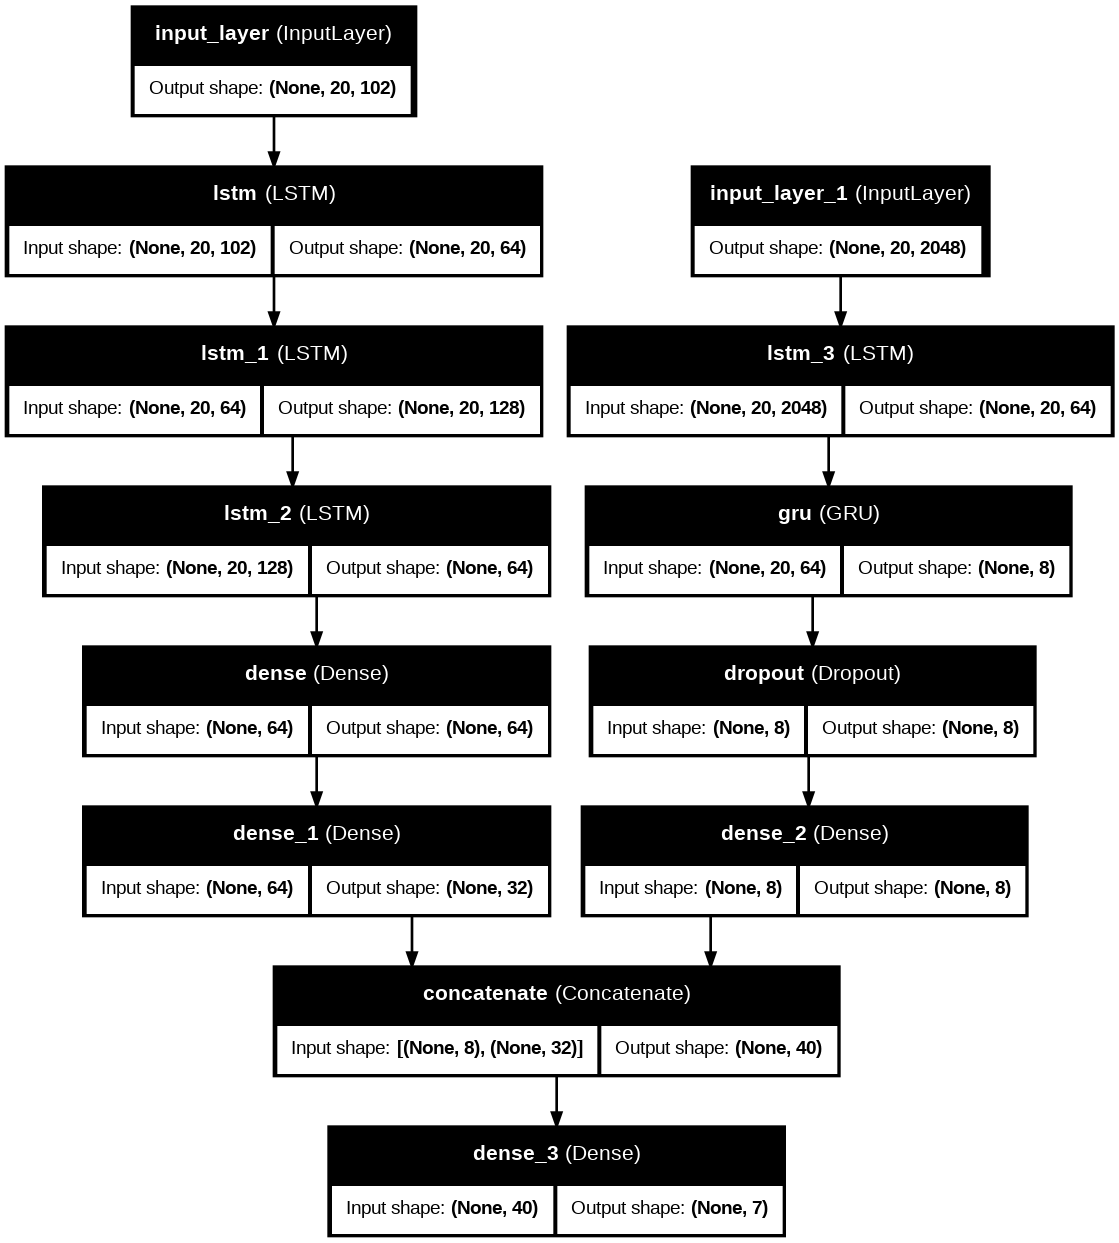

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
gdrive_Path = "/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition"
checkPointName = "Key_mesh__CheckPoint"

# Best model
best_checkpoint_path = f"{gdrive_Path}/{checkPointName}/model_best/best_model.keras"
best_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    best_checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True
)

# Every epoch model
checkpoint_path = f"{gdrive_Path}/{checkPointName}/model/"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path+'model_{epoch:02d}.keras',
    save_freq='epoch'
)

# Reduce learning rate
reduce_callback =  tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=5,
    verbose=1,
    min_lr=1e-7
)

# History
history_path = f"{gdrive_Path}/{checkPointName}/history.txt"
save_history_callback = tf.keras.callbacks.CSVLogger(history_path, append=True)
os.makedirs(os.path.dirname(history_path), exist_ok=True)


In [ ]:
save_model_paths = glob(f'{checkpoint_path}/*.keras')
save_model_paths = sorted(save_model_paths)

save_model_paths

['/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition/Key_mesh__CheckPoint/model/model_01.keras',
 '/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition/Key_mesh__CheckPoint/model/model_02.keras',
 '/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition/Key_mesh__CheckPoint/model/model_03.keras',
 '/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition/Key_mesh__CheckPoint/model/model_04.keras',
 '/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition/Key_mesh__CheckPoint/model/model_05.keras',
 '/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition/Key_mesh__CheckPoint/model/model_06.keras',
 '/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition/Key_mesh__CheckPoint/model/model_07.keras',
 '/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition/Key_mesh__CheckPoint/model/model_08.keras',
 '/content/drive/MyDrive/Colab Notebooks/Human_Activity_Recognition/Key_mesh__CheckPoint/model/model_09.

In [ ]:
initial_epoch = 0

if len(save_model_paths) == 0:
    initial_epoch = 0
else:
    model = tf.keras.models.load_model(save_model_paths[-1])
    initial_epoch = int(save_model_paths[-1].split('_')[-1].split('.')[0])

initial_epoch

15

In [ ]:
# Assuming y_train and y_test are one-hot encoded labels
history = model.fit(
    x=[
        train_mesh_dataset,
        train_keypoints_dataset
    ],
    y=y_train,
    initial_epoch=initial_epoch,
    validation_data=(
        [
            test_mesh_dataset,
            test_keypoints_dataset
        ],
        y_test
    ),
    epochs=epochs,
    batch_size=BATCH_SIZE,
    callbacks=[
        best_checkpoint_callback,
        checkpoint_callback,
        reduce_callback,
        save_history_callback
    ]
)

In [ ]:
def plot_loss_curves_history_path(history_path):
    """
    csv history
    """
    history = pd.read_csv(history_path)
    loss = history['loss']
    val_loss = history['val_loss']

    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    epochs = range(len(history['epoch']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

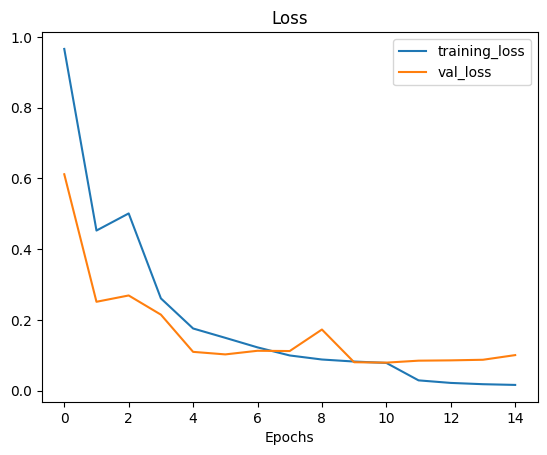

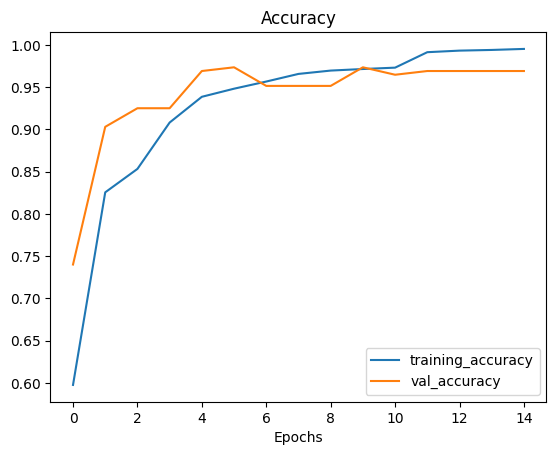

In [ ]:
plot_loss_curves_history_path(history_path)

In [ ]:
y_true_test = np.argmax(y_test, axis=-1)
y_pred_test = model.predict((test_mesh_dataset,test_keypoints_dataset))
y_pred_test = np.argmax(y_pred_test, axis=-1)
y_true_test.shape, y_pred_test.shape

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step


((227,), (227,))

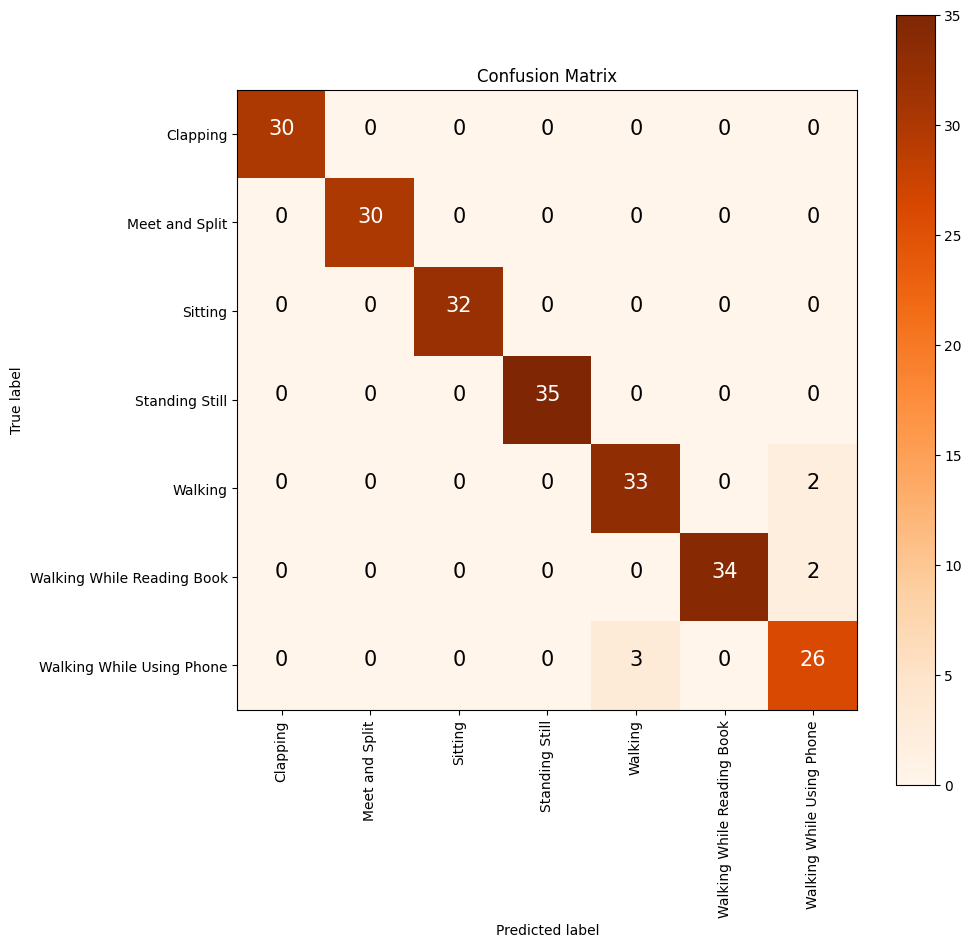

In [ ]:
make_confusion_matrix(y_true_test, y_pred_test, list(class_names))

In [ ]:
results = getPrescisionRecallF1(y_true_test, y_pred_test, class_names)
print(results)
with open(f"{gdrive_Path}/{checkPointName}/PrescisionRecallF1.txt", 'w') as file:
    file.write(results)

        Task           precision      recall        f1       Accuracy 
______________________________________________________________________
      Clapping           1.0000       1.0000       1.0000       1.0000  
   Meet and Split        1.0000       1.0000       1.0000       1.0000  
      Sitting            1.0000       1.0000       1.0000       1.0000  
   Standing Still        1.0000       1.0000       1.0000       1.0000  
      Walking            0.9167       0.9429       0.9296       0.9429  
Walking While Reading Book     1.0000       0.9444       0.9714       0.9444  
Walking While Using Phone     0.8667       0.8966       0.8814       0.8966  
______________________________________________________________________
      Average            0.9690       0.9691       0.9689       0.9692  


# experiment

In [ ]:
! unzip -q finalDataset.zip

In [ ]:
import tensorflow as tf
from glob import glob
from tqdm import tqdm
import os


In [ ]:

blured_final_dir = "finalDataset/bluredImageDataset"
keypoint_final_dir = "finalDataset/keypointDataset"
class_names = sorted([d for d in os.listdir(blured_final_dir+"/train") if os.path.isdir(os.path.join(blured_final_dir+"/train", d))])
class_dict = {x:i for i,x in enumerate(class_names)}
num_classes = len(class_names)
num_classes, class_names, class_dict

(2, ['class_01', 'class_02'], {'class_01': 0, 'class_02': 1})

In [ ]:
import numpy as np
def get_labels(image_dirs):
    labels = []
    for x in image_dirs:
        labels.append(class_dict[x.split("/")[-2]])
    return np.array(labels)

In [ ]:
X_train_paths_1 = sorted(glob(blured_final_dir+"/train/*/*.npy"))
X_train_paths_2 = sorted(glob(keypoint_final_dir+"/train/*/*.npy"))
train_labels = get_labels(X_train_paths_1)

len(X_train_paths_1), len(X_train_paths_2), X_train_paths_1[0], X_train_paths_2[0]

(112,
 112,
 'finalDataset/bluredImageDataset/train/class_01/00000_bai-yao-pu-episode-3-720.npy',
 'finalDataset/keypointDataset/train/class_01/00000_bai-yao-pu-episode-3-720.npy')

In [ ]:
X_test_paths_1 = sorted(glob(blured_final_dir+"/test/*/*.npy"))
X_test_paths_2 = sorted(glob(keypoint_final_dir+"/test/*/*.npy"))
test_labels = get_labels(X_test_paths_1)

len(X_test_paths_1), len(X_test_paths_2), X_test_paths_1[0], X_test_paths_2[0]

(2,
 2,
 'finalDataset/bluredImageDataset/test/class_01/00004_bai-yao-pu-episode-5-720.npy',
 'finalDataset/keypointDataset/test/class_01/00004_bai-yao-pu-episode-5-720.npy')

In [ ]:

y_train = tf.one_hot(train_labels, depth=num_classes)
y_test = tf.one_hot(test_labels, depth=num_classes)

In [ ]:
import tensorflow as tf
import numpy as np

BATCH_SIZE = 32

def load_npy_files(filePath):
    # Load .npy file and return tensor
    data = np.load(filePath.decode("utf-8"))  # decode the file path to string
    return tf.convert_to_tensor(data, dtype=tf.float32)

def create_dataset(mesh_files, keypoints_files, labels, batch_size):
    def load_data(mesh_file, keypoints_file, label):
        # Load mesh and keypoints data from files
        mesh_data = tf.numpy_function(load_npy_files, [mesh_file], tf.float32)
        keypoints_data = tf.numpy_function(load_npy_files, [keypoints_file], tf.float32)
        # Set the shape explicitly after loading the data
        mesh_data.set_shape((20, 2048))  # Assuming your mesh data has this shape
        keypoints_data.set_shape((20, 102)) # Assuming your keypoints data has this shape
        return (mesh_data, keypoints_data), label

    # Create a dataset from file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((mesh_files, keypoints_files, labels))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Create train and test datasets
train_dataset = create_dataset(X_train_paths_1, X_train_paths_2, y_train, BATCH_SIZE)
test_dataset = create_dataset(X_test_paths_1, X_test_paths_2, y_test, BATCH_SIZE)

In [ ]:
for (mesh_data, keypoints_data), labels in train_dataset.take(1):
    print("Mesh data shape:", mesh_data.shape)
    print("Keypoints data shape:", keypoints_data.shape)
    print("Labels shape:", labels.shape)

Mesh data shape: (32, 20, 2048)
Keypoints data shape: (32, 20, 102)
Labels shape: (32, 2)


In [ ]:
for batch_idx, ((mesh_data, keypoints_data), labels) in enumerate(train_dataset):
    # The shapes will be printed during execution
    print("Mesh data shape:", mesh_data.shape)
    print("Keypoints data shape:", keypoints_data.shape)
    print("Labels shape:", labels.shape)
    print()

    # Your model training code here

    if batch_idx >= 1:  # Print shapes for the first 3 batches
        break

    if batch_idx >= 1:  # Print shapes for the first 3 batches
        break

Mesh data shape: (32, 20, 2048)
Keypoints data shape: (32, 20, 102)
Labels shape: (32, 2)

Mesh data shape: (32, 20, 2048)
Keypoints data shape: (32, 20, 102)
Labels shape: (32, 2)



In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import LSTM, Dense, GRU,Dropout, concatenate

# # Define the keypoint model
# model_keypoint = Sequential()
# model_keypoint.add(LSTM(64, return_sequences=True, activation='relu', input_shape=train_keypoints_dataset.shape[1:]))
# model_keypoint.add(LSTM(128, return_sequences=True, activation='relu'))
# model_keypoint.add(LSTM(64, return_sequences=False, activation='relu'))
# model_keypoint.add(Dense(64, activation='relu'))
# model_keypoint.add(Dense(32, activation='relu'))

key_input = Input(shape=(20,102))
x = LSTM(64, return_sequences=True, activation='relu')(key_input)
x = LSTM(128, return_sequences=True, activation='relu')(x)
x = LSTM(64, return_sequences=False, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
key_output = x
model_keypoint = Model(inputs=key_input, outputs=key_output)

# Define the image model
img_input = Input(shape=(20,2048))
x = LSTM(64, return_sequences=True)(img_input)
x = GRU(8)(x)
x = Dropout(0.4)(x)
img_output = Dense(8, activation="relu")(x)
model_img = Model(inputs=img_input, outputs=img_output)

# Concatenate the outputs of both models
combined_output = concatenate([model_img.output, model_keypoint.output])

# Add a Dense layer for the final prediction
output = Dense(num_classes, activation="softmax")(combined_output)

# Create the combined model
model = Model(
    inputs=[
        model_img.input,
        model_keypoint.input
    ],
    outputs=output
)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 20, 102)        │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 20, 2048)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ (None, 20, 64)         │         42,752 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ (None, 20, 64)         │        540,928 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 20, 128)        │         98,816 │ lstm_4[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_1 (GRU)               │ (None, 8)              │          1,776 │ lstm_7[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ (None, 64)             │         49,408 │ lstm_5[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 8)              │              0 │ gru_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 64)             │          4,160 │ lstm_6[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 8)              │             72 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 32)             │          2,080 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 40)             │              0 │ dense_6[0][0],         │
│ (Concatenate)             │                        │                │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 2)              │             82 │ concatenate_1[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 740,074 (2.82 MB)

 Trainable params: 740,074 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=test_dataset
    )

Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 604ms/step - accuracy: 0.6015 - loss: 0.7556 - val_accuracy: 0.5000 - val_loss: 0.7212
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.6571 - loss: 0.6374 - val_accuracy: 0.5000 - val_loss: 0.7152
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.6863 - loss: 0.6393 - val_accuracy: 0.5000 - val_loss: 0.7040
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.6028 - loss: 0.6756 - val_accuracy: 0.5000 - val_loss: 0.6992
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5275 - loss: 0.6919 - val_accuracy: 0.0000e+00 - val_loss: 0.7010
